In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
from zipfile import ZipFile
from sklearn.utils import shuffle

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten,MaxPooling2D
from tensorflow.keras.layers import Lambda, Subtract
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 31 20:47:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [6]:
# If using Google Colab - need to upload eval.zip and train2.zip to local session storage. Below code will unzip them
# If not using Google Colab - need to have eval.zip and train2.zip in same folder as this notebook

with ZipFile('eval.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

with ZipFile('train2.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [7]:
# If using Google Colab - need to upload .xml file to local session storage
# If not using Google Colab - need to have .xml file in same folder as this notebook

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [8]:
def get_person(input, path="train"):
    persons = os.listdir(path)
    if input == 0:
        p1,p2 = tuple(np.random.choice(persons,size=2,replace=False))
        
        #loop to check to make sure there are images in directory
        while len(os.listdir(os.path.join(path,p1)))<1 or len(os.listdir(os.path.join(path,p2)))<1:
            p1,p2 = tuple(np.random.choice(persons,size=2,replace=False))
        
        #loop to make sure webcam photos aren't trained against themselves due to photos placed in separate folders
        while True:
            if "Brady" in p1 and "Brady" in p2:
                p1,p2 = tuple(np.random.choice(persons,size=2,replace=False))
            elif "Panda" in p1 and "Panda" in p2:
                p1,p2 = tuple(np.random.choice(persons,size=2,replace=False))
            else:
                break
        p1 = os.path.join(path,p1,random.choice(os.listdir(os.path.join(path,p1))))
        p2 = os.path.join(path,p2,random.choice(os.listdir(os.path.join(path,p2))))
        p1,p2 = np.expand_dims(cv2.imread(p1,0),-1),np.expand_dims(cv2.imread(p2,0),-1)
    else:
        p = np.random.choice(persons)
        while len(os.listdir(os.path.join(path,p)))<2:
            p = np.random.choice(persons)
        p1,p2 = tuple(np.random.choice( os.listdir(os.path.join(path,p)), size=2, replace=False ))
        p1,p2 = os.path.join(path,p,p1),os.path.join(path,p,p2)
        p1,p2 = np.expand_dims(cv2.imread(p1,0),-1),np.expand_dims(cv2.imread(p2,0),-1)
    
    return p1,p2

In [13]:
def getBatch(batch_size=32,prob=0.5,path = "train"):
    persons = os.listdir(path)
    left = []
    right = []
    target = []
    batchPairs = []
    for _ in range(batch_size):
        res = np.random.choice([0,1],p=[1-prob,prob])
        if res==0:
            p1,p2 = get_person(res, path)
            pairs = []
            
            #apply haar face cascade and check for one face in each image
            face_check = True
            while face_check:
                p1_faces = face_cascade.detectMultiScale(p1, 1.3, 5)
                p2_faces = face_cascade.detectMultiScale(p2, 1.3, 5)
                
                if len(p1_faces) == 1 and len(p2_faces) == 1:
                    face_check = False
                else:
                    p1,p2 = get_person(res, path)
             
            x,y,w,h = p1_faces[0]
            p1_resized = cv2.resize(p1[y:y+h, x:x+w, :], (100,100), interpolation = cv2.INTER_AREA)
            x,y,w,h = p2_faces[0]
            p2_resized = cv2.resize(p2[y:y+h, x:x+w, :], (100,100), interpolation = cv2.INTER_AREA)
            
            pairs.append(p1_resized)
            pairs.append(p2_resized)
            left.append(p1_resized)
            right.append(p2_resized)
            batchPairs.append(pairs)
            target.append(0)
        else:
            p1,p2 = get_person(res, path)
            pairs = []

            #apply haar face cascade and check for one face in each image
            face_check = True
            while face_check:
                p1_faces = face_cascade.detectMultiScale(p1, 1.3, 5)
                p2_faces = face_cascade.detectMultiScale(p2, 1.3, 5)
                
                if len(p1_faces) == 1 and len(p2_faces) == 1:
                    face_check = False
                else:
                    p1,p2 = get_person(res, path)
            
            x,y,w,h = p1_faces[0]
            p1_resized = cv2.resize(p1[y:y+h, x:x+w, :], (100,100), interpolation = cv2.INTER_AREA)
            x,y,w,h = p2_faces[0]
            p2_resized = cv2.resize(p2[y:y+h, x:x+w, :], (100,100), interpolation = cv2.INTER_AREA)
            
            pairs.append(p1_resized)
            pairs.append(p2_resized)
            left.append(p1_resized)
            right.append(p2_resized)
            batchPairs.append(pairs)
            target.append(1)

            #return batchPairs as well if wanting to test
    return [np.array(left),np.array(right)],np.array(target)

In [10]:
def Weight_init(shape,name=None,dtype=None):
    return K.variable(np.random.normal(loc=0,scale=1e-2,size=shape),name=name)

def Bias_init(shape,name=None,dtype=None):
    return K.variable(np.random.normal(loc=0.5,scale=1e-2,size=shape),name=name)

input_shape = (100, 100, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

#SNN layers
cnn = Sequential()
cnn.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,kernel_initializer=Weight_init,kernel_regularizer=l2(2e-4)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128,(7,7),activation='relu', kernel_regularizer=l2(2e-4),kernel_initializer=Weight_init,bias_initializer=Bias_init))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=Weight_init,kernel_regularizer=l2(2e-4),bias_initializer=Bias_init))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=Weight_init,kernel_regularizer=l2(2e-4),bias_initializer=Bias_init))
cnn.add(Flatten())
cnn.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=Weight_init,bias_initializer=Bias_init))

#encode each input into a vector
encoded_l = cnn(left_input)
encoded_r = cnn(right_input)

#merge two encoded inputs with the l1 distance between them
subtracted = Subtract()( [encoded_l,encoded_r]  )
distance = Lambda(lambda x: abs(x))(subtracted)
prediction = Dense(1,activation='sigmoid',bias_initializer=Bias_init)(distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006) #learning rate
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)


In [11]:
siamese_net.count_params()

27417409

In [12]:
def test_model(model,N):
    inputs, targets = getBatch(N,path="eval") #receive batchPairs as well if wanting to test
    probs = model.predict(inputs)
    output = (np.squeeze(probs)>0.5)*1
    accuracy = (output==targets).sum()*100/N
    print("Model averaged {}% accuracy on {} pairs of one-shot learning".format(accuracy,N))
    
    # Below code for testing purposes
    # prints out pairs and prediction made for batch
    # for count, i in enumerate(batchPairs):
    #     p1_resized,p2_resized = i
    #     plt.figure(figsize=(10,10))
    #     plt.subplot(1,2,1)
    #     plt.imshow(p1_resized)

    #     plt.subplots_adjust(bottom=0.1)
    #     plt.text(-5,-5,probs[count])

    #     plt.subplot(1,2,2)
    #     plt.imshow(p2_resized)
    
    return accuracy

In [16]:
loss_every = 500
batch_size = 32
N = 1000 #how many pairs to test the model on untrained images
best = 0 #best % accuracy on N pairs
# 500 iterations = 1 epoch
loss_history = [] #holds the training loss for 1 epoch and resets for each - holds each iteration (500) to calculate mean loss over each epoch
tloss_history = [] #holds the traning loss for each epoch (1 for every 500 iterations)
vloss_history = [] #holds the validation loss for each epoch
acc_history = [] #holds the accuracy of N shot learning for epoch
epoch_history = [] #holds the number of epochs
for i in range(0,20000):
    inputs, targets = getBatch(batch_size,path="train") #get batchPairs if testing
    loss=siamese_net.train_on_batch(inputs,targets)
    loss_history.append(loss)
    if i % loss_every == 0:
        test_in, test_target = getBatch(batch_size, path="eval") #get testPairs if testing
        vloss = siamese_net.test_on_batch(test_in, test_target)

        tloss_history.append(loss)
        vloss_history.append(vloss)
        epoch_history.append(i/loss_every)

        print("iteration {}, training loss: {:.7f}, validation loss : {:.7f}".format(i,np.mean(loss_history),vloss))
        loss_history.clear() #clears loss history for new epoch calculation

        val_acc = test_model(siamese_net,N)
        acc_history.append(val_acc) #append accuracy to array for history
      
        if val_acc >= best:
            siamese_net.save('gdrive/MyDrive/best_model') #saves the best performing model via accuracy to google drive
            print("Model saved")
            best=val_acc

iteration 0, training loss: 3.3147652, validation loss : 3.3434184
Model averaged 51.7% 1000 way one-shot learning accuracy
Model saved
iteration 500, training loss: 1.7034601, validation loss : 1.0054305
Model averaged 64.8% 1000 way one-shot learning accuracy
Model saved
iteration 1000, training loss: 0.8422368, validation loss : 0.7287202
Model averaged 69.8% 1000 way one-shot learning accuracy
Model saved
iteration 1500, training loss: 0.6122687, validation loss : 0.5640979
Model averaged 72.5% 1000 way one-shot learning accuracy
Model saved
iteration 2000, training loss: 0.4954249, validation loss : 0.7922347
Model averaged 70.5% 1000 way one-shot learning accuracy
iteration 2500, training loss: 0.4098725, validation loss : 0.7921818
Model averaged 71.2% 1000 way one-shot learning accuracy
iteration 3000, training loss: 0.3641707, validation loss : 0.9063095
Model averaged 74.7% 1000 way one-shot learning accuracy
Model saved
iteration 3500, training loss: 0.3293568, validation lo

KeyboardInterrupt: ignored

In [ ]:
# Can run this multiple times to test N way one-shot accuracy
model_acc = test_model(siamese_net,1000)

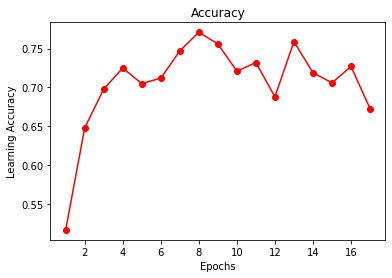

In [15]:
plt.plot(epoch_history,acc_history, color='red', marker='o')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Learning Accuracy')
plt.show()

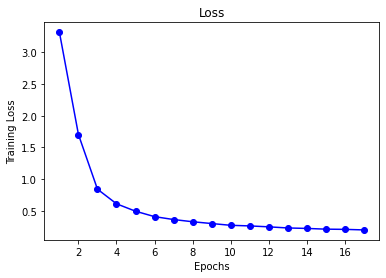

In [17]:
plt.plot(epoch_history,tloss_history, color='blue', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

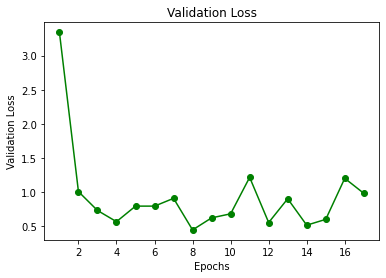

In [18]:
plt.plot(epoch_history,vloss_history, color='green', marker='o')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()